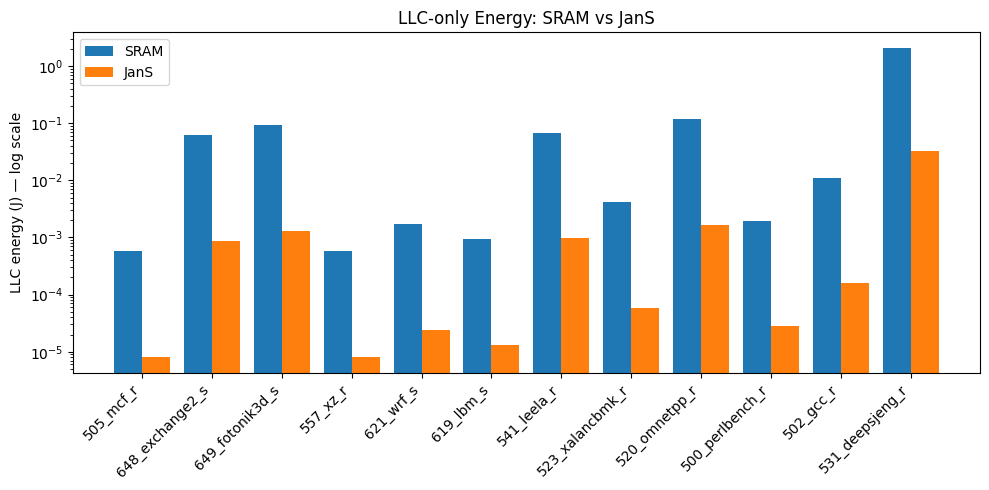

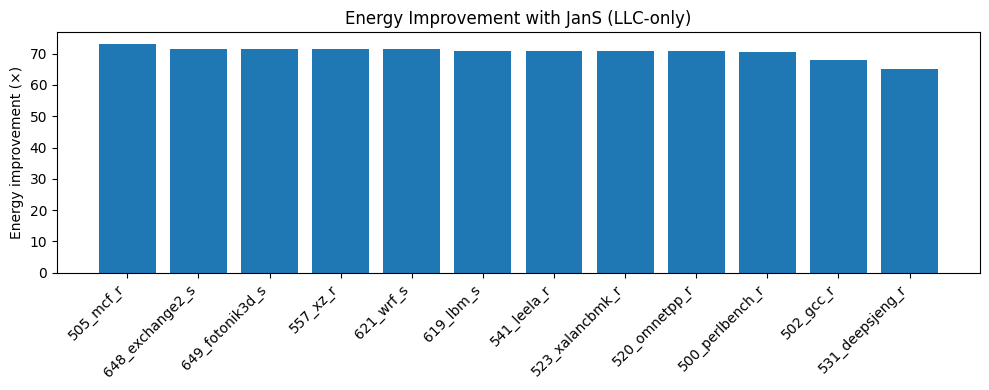

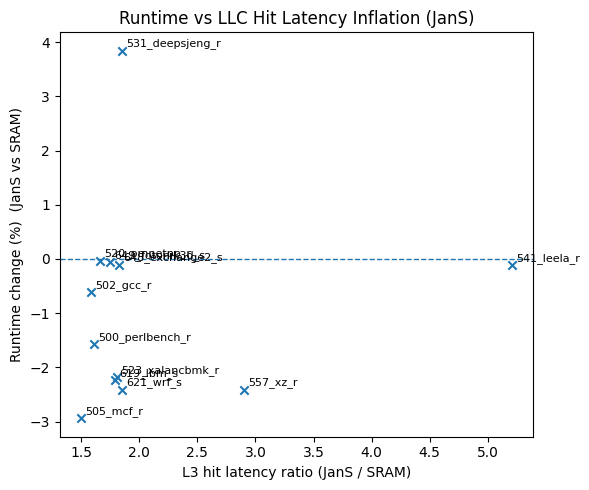

Benchmarks: 12
Median energy improvement (×): 70.9214342948718
Median runtime delta (%): -1.0883706171664342
Median hit-latency ratio: 1.7995124666854125


In [1]:
#!/usr/bin/env python3
# Visualize LLC-only results for JanS vs SRAM
# Assumes each output_* dir contains energy_bounds.csv and summary.csv

import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Config (absolute paths) ----
RUN_ID  = "test_all_spec_benchmarks20250920T204859Z"
RUN_DIR = f"/home/skataoka26/COSC_498/miniMXE/results/{RUN_ID}"

# ---- Load energy_bounds.csv from all output_* dirs ----
energy_files = sorted(glob.glob(os.path.join(RUN_DIR, "output_*", "energy_bounds.csv")))
if not energy_files:
    raise SystemExit(f"No energy_bounds.csv found under {RUN_DIR}")

dfE = pd.concat([pd.read_csv(f) for f in energy_files], ignore_index=True)

# Keep only the fields we need
dfE = dfE[[
    "benchmark", "n_m", "config", "time_s", "energy_exact_J", "ed2p_exact_J_s2"
]]

# Normalize types
for col in ["time_s", "energy_exact_J", "ed2p_exact_J_s2"]:
    dfE[col] = pd.to_numeric(dfE[col], errors="coerce")

# Pivot to get columns per config (SRAM, JanS)
E_piv = dfE.pivot_table(index="benchmark", columns="config",
                        values=["time_s", "energy_exact_J", "ed2p_exact_J_s2"],
                        aggfunc="first")

# Convenience columns
def pick(col, cfg):
    return E_piv[(col, cfg)] if (col, cfg) in E_piv.columns else np.nan

benchmarks = E_piv.index.tolist()
sram_E   = pick("energy_exact_J", "SRAM")
jans_E   = pick("energy_exact_J", "JanS")
sram_T   = pick("time_s", "SRAM")
jans_T   = pick("time_s", "JanS")
sram_ED2P = pick("ed2p_exact_J_s2", "SRAM")
jans_ED2P = pick("ed2p_exact_J_s2", "JanS")

# ---- Load summary.csv from all output_* dirs (for avg_L3_hit_ns) ----
summary_files = sorted(glob.glob(os.path.join(RUN_DIR, "output_*", "summary.csv")))
dfS = pd.concat([pd.read_csv(f) for f in summary_files], ignore_index=True)
dfS = dfS[["benchmark", "config", "avg_l3_hit_ns"]]
dfS["avg_l3_hit_ns"] = pd.to_numeric(dfS["avg_l3_hit_ns"], errors="coerce")
S_piv = dfS.pivot_table(index="benchmark", columns="config",
                        values="avg_l3_hit_ns", aggfunc="first")

sram_hit_ns = S_piv["SRAM"] if "SRAM" in S_piv.columns else pd.Series(index=benchmarks, dtype=float)
jans_hit_ns = S_piv["JanS"] if "JanS" in S_piv.columns else pd.Series(index=benchmarks, dtype=float)

# ---- Build analysis frame ----
df = pd.DataFrame({
    "benchmark": benchmarks,
    "sram_energy_J": sram_E.values,
    "jans_energy_J": jans_E.values,
    "sram_time_s":   sram_T.values,
    "jans_time_s":   jans_T.values,
    "sram_avg_l3_hit_ns": sram_hit_ns.reindex(benchmarks).values,
    "jans_avg_l3_hit_ns": jans_hit_ns.reindex(benchmarks).values,
    "sram_ed2p": sram_ED2P.values,
    "jans_ed2p": jans_ED2P.values,
}).dropna(subset=["sram_energy_J","jans_energy_J","sram_time_s","jans_time_s"])

df["energy_ratio_SRAM_over_JanS"] = df["sram_energy_J"] / df["jans_energy_J"]
df["time_delta_pct"] = 100.0 * (df["jans_time_s"] - df["sram_time_s"]) / df["sram_time_s"]
df["hit_ns_ratio_JanS_over_SRAM"] = df["jans_avg_l3_hit_ns"] / df["sram_avg_l3_hit_ns"]
df["ed2p_ratio_SRAM_over_JanS"] = df["sram_ed2p"] / df["jans_ed2p"]

# Order by energy improvement
df_sorted = df.sort_values("energy_ratio_SRAM_over_JanS", ascending=False).reset_index(drop=True)

# =========================
# Plot 1: LLC energy by benchmark (log scale)
# =========================
plt.figure(figsize=(10,5))
x = np.arange(len(df_sorted))
width = 0.4
plt.bar(x - width/2, df_sorted["sram_energy_J"], width, label="SRAM")
plt.bar(x + width/2, df_sorted["jans_energy_J"], width, label="JanS")
plt.yscale("log")
plt.xticks(x, df_sorted["benchmark"], rotation=45, ha="right")
plt.ylabel("LLC energy (J) — log scale")
plt.title("LLC-only Energy: SRAM vs JanS")
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# Plot 2: Energy improvement factor (SRAM / JanS)
# =========================
plt.figure(figsize=(10,4))
x = np.arange(len(df_sorted))
plt.bar(x, df_sorted["energy_ratio_SRAM_over_JanS"])
plt.xticks(x, df_sorted["benchmark"], rotation=45, ha="right")
plt.ylabel("Energy improvement (×)")
plt.title("Energy Improvement with JanS (LLC-only)")
plt.tight_layout()
plt.show()

# =========================
# Plot 3: Runtime change vs. L3 hit-latency ratio
# =========================
plt.figure(figsize=(6,5))
xr = df["hit_ns_ratio_JanS_over_SRAM"].values
yr = df["time_delta_pct"].values
plt.scatter(xr, yr, marker="x")
for i, row in df.iterrows():
    if not (np.isnan(row["hit_ns_ratio_JanS_over_SRAM"]) or np.isnan(row["time_delta_pct"])):
        plt.annotate(row["benchmark"], (row["hit_ns_ratio_JanS_over_SRAM"], row["time_delta_pct"]),
                     fontsize=8, xytext=(3,3), textcoords="offset points")
plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("L3 hit latency ratio (JanS / SRAM)")
plt.ylabel("Runtime change (%)  (JanS vs SRAM)")
plt.title("Runtime vs LLC Hit Latency Inflation (JanS)")
plt.tight_layout()
plt.show()

# (Optional) print a quick summary
print("Benchmarks:", len(df_sorted))
print("Median energy improvement (×):", df["energy_ratio_SRAM_over_JanS"].median())
print("Median runtime delta (%):", df["time_delta_pct"].median())
print("Median hit-latency ratio:", df["hit_ns_ratio_JanS_over_SRAM"].median())
